In [20]:
import os
from datetime import datetime, timedelta
from pathlib import Path

from pyannote.audio import Pipeline
from pydub import AudioSegment
import wave, json

import numpy as np

In [21]:
# Read mp3 file and convert to 16kHz mono

mp3_path = "audio/KLAS4-ZLA16-Jul-01-2025-1500Z.mp3"

audio = AudioSegment.from_mp3(mp3_path).set_channels(1).set_frame_rate(16000)
test_audio = audio[:20*1000] # four first lines of transcript
test_audio

In [22]:
samples = np.array(test_audio.get_array_of_samples()).astype(np.float16)
samples /= np.max(np.abs(samples))
sample_rate = test_audio.frame_rate
duration = len(samples) / sample_rate

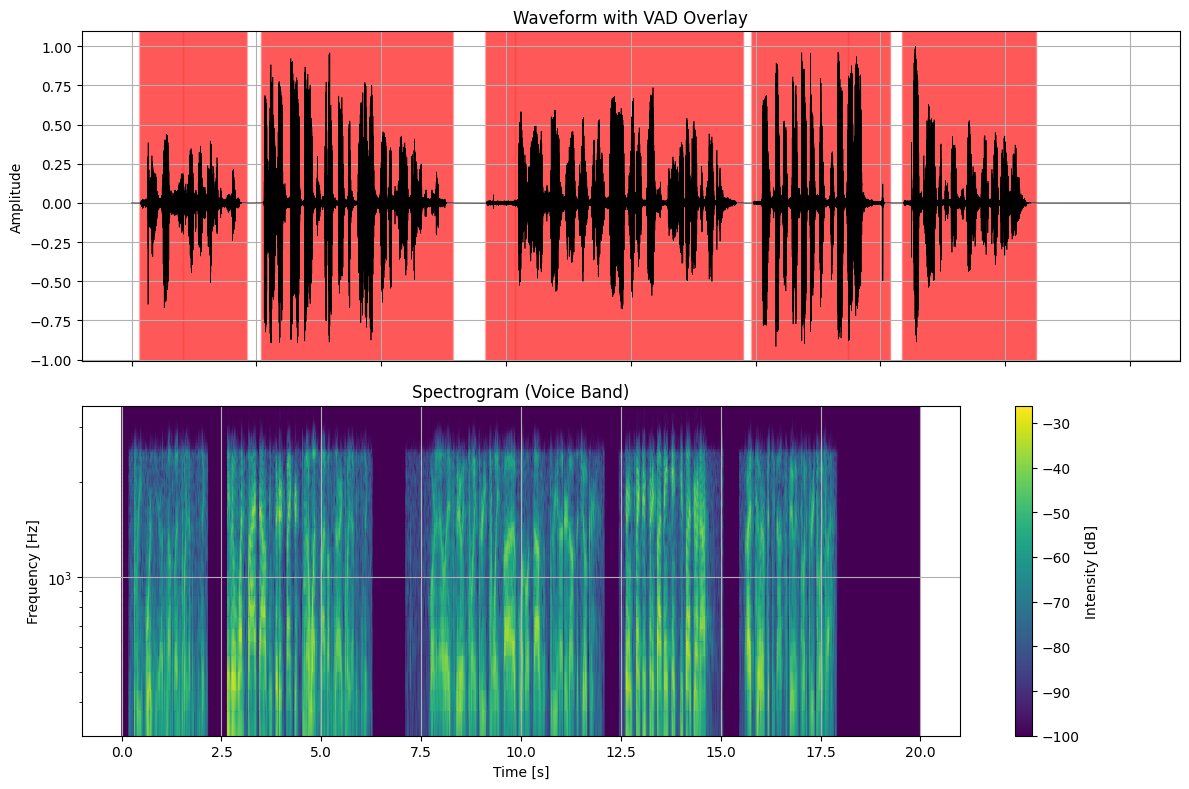

In [23]:
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import webrtcvad

voice_band=(300, 3500)
log_freq = True

freqs, times, Sxx = spectrogram(samples, fs=sample_rate)
voice_mask = (freqs >= voice_band[0]) & (freqs <= voice_band[1])
freqs = freqs[voice_mask]
Sxx = Sxx[voice_mask]


# Voice Activity Detection
vad = webrtcvad.Vad(3)
frame_duration = 10  # ms
frame_size = int(sample_rate * frame_duration / 1000)
num_frames = len(samples) // frame_size

speech_regions = []
for i in range(num_frames):
    start = i * frame_size
    end = start + frame_size
    frame = samples[start:end]
    if len(frame) < frame_size:
        continue
    is_speech = vad.is_speech(frame.tobytes(), sample_rate)
    if is_speech:
        start_time = start / sample_rate
        end_time = end / sample_rate
        speech_regions.append((start_time, end_time))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot waveform
time_axis = np.linspace(0, duration, len(samples))
ax1.plot(time_axis, samples, color='black', linewidth=0.5)
ax1.set_title("Waveform with VAD Overlay")
ax1.set_ylabel("Amplitude")
ax1.grid(True)

for start, end in speech_regions:
    ax1.axvspan(start, end, color='red', alpha=0.2)

# Plot spectrogram
pcm = ax2.pcolormesh(times, freqs, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
ax2.set_title("Spectrogram (Voice Band)")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_xlabel("Time [s]")
if log_freq:
    ax2.set_yscale('log')
fig.colorbar(pcm, ax=ax2, label="Intensity [dB]")
ax2.grid(True)

# for start, end in speech_regions:
#     ax2.axvspan(start, end, color='red', alpha=0.2)

plt.tight_layout()
plt.show()

In [24]:
def vad_split_segments(mp3_path, frame_duration_ms=30, aggressiveness=2, min_speech_ms=300):
    # Load and convert audio
    audio = AudioSegment.from_mp3(mp3_path).set_channels(1).set_frame_rate(16000)
    samples = np.array(audio.get_array_of_samples()).astype(np.int16)
    sample_rate = 16000
    bytes_per_sample = 2

    # Frame configuration
    frame_size = int(sample_rate * frame_duration_ms / 1000)
    vad = webrtcvad.Vad(aggressiveness)

    speech_segments = []
    current_chunk = b''
    start_time = None
    times = []

    for i in range(0, len(samples) - frame_size, frame_size):
        frame = samples[i:i+frame_size]
        frame_bytes = frame.tobytes()

        is_speech = vad.is_speech(frame_bytes, sample_rate)
        timestamp = i / sample_rate

        if is_speech:
            if start_time is None:
                start_time = timestamp
            current_chunk += frame_bytes
        else:
            if current_chunk:
                duration = len(current_chunk) / (sample_rate * bytes_per_sample)
                if duration * 1000 >= min_speech_ms:
                    end_time = timestamp
                    chunk_audio = AudioSegment(
                        data=current_chunk,
                        sample_width=bytes_per_sample,
                        frame_rate=sample_rate,
                        channels=1,
                    )
                    speech_segments.append((start_time, end_time, chunk_audio))
                    times.append((start_time, end_time))
                current_chunk = b''
                start_time = None

    # Handle last chunk
    if current_chunk and start_time is not None:
        end_time = len(samples) / sample_rate
        chunk_audio = AudioSegment(
            data=current_chunk,
            sample_width=bytes_per_sample,
            frame_rate=sample_rate,
            channels=1,
        )
        speech_segments.append((start_time, end_time, chunk_audio))
        times.append((start_time, end_time))

    return speech_segments

In [25]:
chunks = vad_split_segments(mp3_path, frame_duration_ms=30, aggressiveness=1, min_speech_ms=300)

In [26]:
chunks[:4]

[(0.24, 2.37, <pydub.audio_segment.AudioSegment at 0x1552d94172f0>),
 (2.61, 6.48, <pydub.audio_segment.AudioSegment at 0x1552da719910>),
 (7.11, 12.24, <pydub.audio_segment.AudioSegment at 0x1552d98eb9b0>),
 (12.45, 15.24, <pydub.audio_segment.AudioSegment at 0x155344f9a480>)]

In [59]:
chunks[:4][3][2]